In [2]:
import numpy as np
import pandas as pd
%matplotlib inline

from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('../Data/M2SLMoneyStock.csv', index_col=0, parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv('../Data/PCEPersonalSpending.csv', index_col=0, parse_dates=True)
sp.index.freq = 'MS'

In [4]:
df = df.join(sp)
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [5]:
df = df.dropna()
len(df)

252

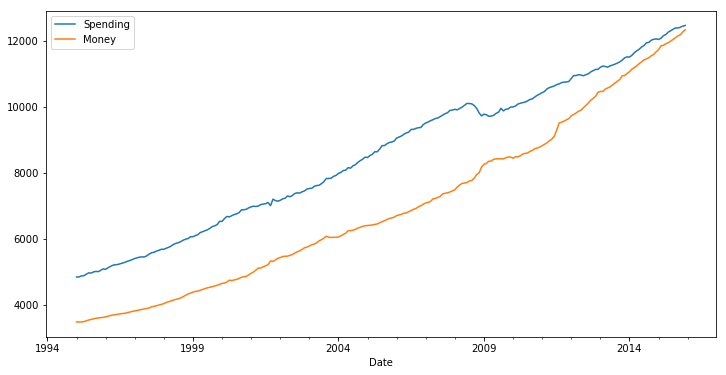

In [7]:
df['Spending'].plot(figsize=(12, 6), legend=True)
df['Money'].plot(legend=True);

#### Test for Stationarity

In [8]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [9]:
auto_arima(df['Money'], maxiter=1000).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(1, 2, 2)   Log Likelihood               -1172.257
Date:                Mon, 29 Aug 2022   AIC                           2354.514
Time:                        11:14:00   BIC                           2372.121
Sample:                             0   HQIC                          2361.600
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0723      0.037      1.932      0.053      -0.001       0.146
ar.L1          0.5989      0.170      3.528      0.000       0.266       0.932
ma.L1         -1.3808      1.758     -0.786      0.432      -4.826       2.064
ma.L2          0.3808      0.726      0.525      0.600      -1.042       1.804
sigma2       679.5393   1154.621      0.589      0.556   -1583.476    2942.555
===================================================================================
Ljung-Box (Q):                       77.23   Jarque-Bera (JB):               576.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.47   Skew:                             1.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
auto_arima(df['Spending'], maxiter=1000).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -1238.601
Date:                Mon, 29 Aug 2022   AIC                           2487.202
Time:                        11:14:26   BIC                           2504.829
Sample:                             0   HQIC                          2494.295
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.7216      3.525      1.907      0.057      -0.186      13.630
ar.L1          0.7775      0.120      6.470      0.000       0.542       1.013
ma.L1         -0.7890      0.117     -6.767      0.000      -1.017      -0.560
ma.L2          0.1342      0.062      2.171      0.030       0.013       0.255
sigma2      1131.1366     61.857     18.286      0.000    1009.900    1252.374
===================================================================================
Ljung-Box (Q):                       34.25   Jarque-Bera (JB):               216.24
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                            -0.30
Prob(H) (two-sided):                  0.92   Kurtosis:                         7.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
df_transformed = df.diff().diff()
df_transformed = df_transformed.dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


#### Train-Test Split

In [12]:
nobs = 12
train = df_transformed[:-nobs]
test = df_transformed[-nobs:]

#### Fit VARMA(1,2) Model

In [14]:
model = VARMAX(train, order=(1, 2))
results = model.fit(maxiter=1000, disp=False)
results.summary()

Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2286.620
,+ intercept,AIC,4607.240
Date:,"Mon, 29 Aug 2022",BIC,4666.269
Time:,11:20:57,HQIC,4631.030
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (Q):,"68.26, 28.80",Jarque-Bera (JB):,"550.93, 117.16"
Prob(Q):,"0.00, 0.91",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.60, 2.91",Skew:,"1.34, -0.35"


#### Predict next 12 values

In [15]:
df_forecast = results.forecast(12)
df_forecast

,Money,Spending
2015-01-01,-11.407362,36.823004
2015-02-01,-11.478305,-4.096214
2015-03-01,1.840614,-0.335133
2015-04-01,-2.025606,-0.190566
2015-05-01,1.426395,0.197637
2015-06-01,-0.681016,0.031007
2015-07-01,0.738129,0.157216
2015-08-01,-0.191154,0.077097
2015-09-01,0.422116,0.130439
2015-10-01,0.018277,0.095399


#### Invert Transformation

In [17]:
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1] - df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money1d'].cumsum()

In [18]:
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1] - df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending1d'].cumsum()

In [19]:
df_forecast

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-11.407362,36.823004,67.192638,11737.292638,47.423004,12109.423004
2015-02-01,-11.478305,-4.096214,55.714334,11793.006972,43.326789,12152.749793
2015-03-01,1.840614,-0.335133,57.554947,11850.561919,42.991657,12195.741449
2015-04-01,-2.025606,-0.190566,55.529341,11906.091260,42.801091,12238.542540
2015-05-01,1.426395,0.197637,56.955736,11963.046996,42.998728,12281.541268
2015-06-01,-0.681016,0.031007,56.274720,12019.321716,43.029735,12324.571004
2015-07-01,0.738129,0.157216,57.012849,12076.334565,43.186951,12367.757955
2015-08-01,-0.191154,0.077097,56.821695,12133.156260,43.264048,12411.022002
2015-09-01,0.422116,0.130439,57.243810,12190.400070,43.394486,12454.416489
2015-10-01,0.018277,0.095399,57.262088,12247.662157,43.489886,12497.906374


In [20]:
# Concatenating Forecast values and actual values
pd.concat([df.iloc[-12:], df_forecast[['MoneyForecast', 'SpendingForecast']]], axis=1)

,Money,Spending,MoneyForecast,SpendingForecast
Date,,,,
2015-01-01,11733.2,12046.0,11737.292638,12109.423004
2015-02-01,11852.4,12082.4,11793.006972,12152.749793
2015-03-01,11868.8,12158.3,11850.561919,12195.741449
2015-04-01,11916.1,12193.8,11906.091260,12238.542540
2015-05-01,11947.6,12268.1,11963.046996,12281.541268
2015-06-01,11993.1,12308.3,12019.321716,12324.571004
2015-07-01,12045.3,12355.4,12076.334565,12367.757955
2015-08-01,12096.8,12394.0,12133.156260,12411.022002
2015-09-01,12153.8,12392.8,12190.400070,12454.416489


#### Plot results

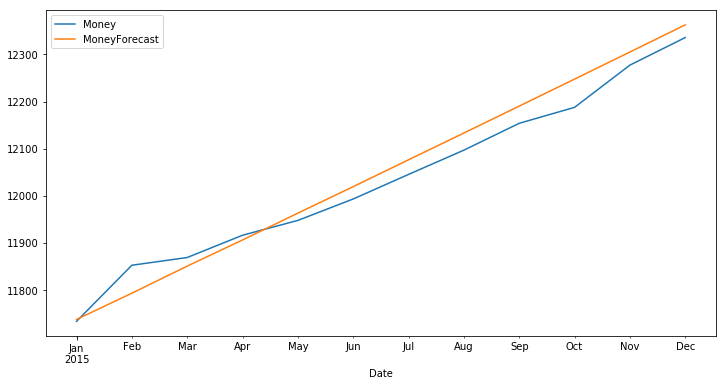

In [22]:
df['Money'][-nobs:].plot(figsize=(12, 6), legend=True)
df_forecast['MoneyForecast'].plot(legend=True);

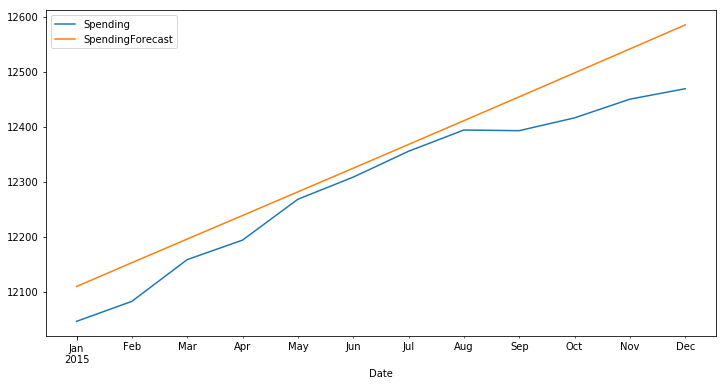

In [23]:
df['Spending'][-nobs:].plot(figsize=(12, 6), legend=True)
df_forecast['SpendingForecast'].plot(legend=True);

#### Evaluate Model

In [24]:
rmse_money = rmse(df['Money'][-nobs:], df_forecast['MoneyForecast'])
print('rmse_money {}'.format(round(rmse_money, 3)))

rmse_money 33.694


In [25]:
rmse_spending = rmse(df['Spending'][-nobs:], df_forecast['SpendingForecast'])
print('rmse_spending {}'.format(round(rmse_spending, 3)))

rmse_spending 61.64
